Misspecified MC Simulation

In [10]:
import MC_functions as mc
import os
import numpy as np
from scipy import dot
import pandas as pd
from scipy.stats import multivariate_t
from scipy.linalg import eigh
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
import multiprocessing as mp
import concurrent.futures
import matplotlib.pyplot as plt
from tabulate import tabulate
import gc

In [11]:
# Simulation parameters
number_of_variables = 1
w = 2
beta = np.array([2]) # in the multivariate case, just add elements until the size of the vector is equal to number_of_variables
N1 = 80
N2 = 10
T = 5
n = N1 * N2 * T
case = 3 # correspond to the three cases of omega in the chapter
mu_epsilon = 0
sigma_epsilon = 8
non_zero_prob = 0.6
mu_x = 0
sigma_x = 1
mu_z = 0
sigma_z = 1
mu_d = 0
sigma_d = 1
mu_v = 0
sigma_v = 5
mu_z = 0
sigma_z = 5
specification = "normal" # "normal", "t" or "sn"
mu_e = 0
mu_e_vec= np.full(n, mu_e)
sigma_e = 1
t_dist_degree = 5
mu_U = 0

# Define the block dimensions
if case ==2:
    block_size = N2  # Adjust this to your specific block size
elif case == 3:
    block_size = T

# Determine the total number of blocks
num_blocks = n // block_size

# spcov parameters
lambda_parameter = 2
spcov = importr("spcov")
max_penalty = 1
ksi_1 = 12  # controls the smallest penalty, the higher the value the smaller 
ksi_2 = 1.5   # flattening parameter for sigmoid penalty function
seed = 42
np.random.seed(seed)

# for computational reasons, we have to add a term eta to the diagonal, and also set small values that are close to zero to actual zero, because those are due to numerical errors
eta = 1e-5
tolerance = 1e-11

In [12]:
rpy2.robjects.numpy2ri.activate()

In [13]:
# Initialize the R context for each thread or process
def initialize_r_context():
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    import rpy2.robjects.numpy2ri
    
    # Activate numpy2ri conversion within the local R context
    rpy2.robjects.numpy2ri.activate()    
    spcov = importr("spcov")

In [14]:
z = np.random.normal(-2, 1, (N1*N2, 1))
z = np.tile(z, (T, 1))
d = np.random.normal(mu_d, sigma_d, (n, number_of_variables))
x = z + d
v = np.random.normal(mu_v, sigma_v, (n, 1))
g = w * z + v
disturbances = np.random.normal(mu_e, sigma_e, (n, 1))
y = np.dot(x, beta) + g.flatten() + disturbances.flatten()

In [15]:
# Step 1: Generate three fixed-effect variables
fixed_effect_1 = np.random.normal(-2, 1, (N1, 1))
fixed_effect_2 = np.random.normal(3, 1, (N2, 1))
fixed_effect_3 = np.random.normal(1, 1, (T, 1))
z = np.random.normal(mu_z, sigma_z, (N1*N2, 1))

# Step 2: Repeat the fixed-effect variables to match the desired dimensions
fixed_effect_1 = np.repeat(fixed_effect_1, N2 * T, axis=0)
fixed_effect_2 = np.tile(fixed_effect_2, (N1 * T, 1))
fixed_effect_3 = np.tile(fixed_effect_3, (N1 * N2, 1))
z = np.tile(z, (T, 1))

# Step 3: Stack the fixed-effect variables and combine x and fixed effects
fixed_effects_matrix = np.hstack((fixed_effect_1, fixed_effect_2, fixed_effect_3))

# Step 4: Generate x
d = np.random.normal(mu_d, sigma_d, (n, number_of_variables))
x = z + d
v = np.random.normal(mu_v, sigma_v, (n, 1))
g = w * z + v

X = np.hstack((x, fixed_effects_matrix))


# Step 5: generate distrubances using the covariance matrix
#omega = mc.generate_omega(case, mu_e, sigma_e, non_zero_prob, N1, N2, T, seed)
#disturbances = mc.generate_disturbances(mu_e_vec, omega, n, t_dist_degree, lambda_parameter, mu_U, specification, seed)
disturbances = np.random.normal(mu_e, sigma_e, (n, 1))

# Step 6: Generate y using linear relationship: y = X * beta + FE + disturbances
#y = np.dot(x, beta) + fixed_effects_matrix.sum(axis=1) + disturbances.flatten()
y = np.dot(x, beta) + g.flatten() + disturbances.flatten()

# Step 7: Transform X and y
x_tilde, y_tilde = mc.transform_xy(X, y,number_of_variables)
X = np.hstack((x_tilde, fixed_effects_matrix))
y = y_tilde

# Step 8: Estimate beta using OLS formula
X_with_intercept = np.hstack((np.ones((n, 1)), X))  # Adding intercept term
X_transpose = np.transpose(X_with_intercept)
X_transpose_X_inv = np.linalg.inv(np.dot(X_transpose, X_with_intercept))
beta_hat = np.dot(np.dot(X_transpose_X_inv, X_transpose), y)

# Step 9: Calculate the variance-covariance matrix of beta_hat
# OLS
epsilon_hat = y - np.dot(X_with_intercept, beta_hat)
omega_hat = np.dot(epsilon_hat, epsilon_hat)/(n-number_of_variables-4)
sigma_hat = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat), X_with_intercept),X_transpose_X_inv)

# robust
omega_hat_robust = np.outer(epsilon_hat, epsilon_hat)
omega_hat_robust = np.eye(omega_hat_robust.shape[0]) * omega_hat_robust
sigma_hat_robust = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_robust), X_with_intercept),X_transpose_X_inv)

# spcov
# Initialize an empty omega_hat matrix
omega_hat_spcov = np.zeros((n, n))
S_mat_full = np.outer(epsilon_hat, epsilon_hat)
block_omega_hat_spcov_list = []

# Extract blocks and average them
init_omega_blocks = mc.extract_blocks(omega_hat_robust, block_size)
init_omega = np.mean(init_omega_blocks, axis=0)
S_mat_blocks = mc.extract_blocks(S_mat_full, block_size)
S_mat = np.mean(S_mat_blocks, axis=0)
S_mat = mc.make_positive_definite(S_mat)

# spcov
Lambda = mc.generate_penalty_matrix(max_penalty, block_size, ksi_1, ksi_2)
init_omega_r = ro.r.matrix(init_omega, nrow=block_size, ncol=block_size)
S_r = ro.r.matrix(S_mat, nrow=block_size, ncol=block_size)
Lambda_r = ro.r.matrix(Lambda, nrow=block_size, ncol=block_size)
spcov_result = spcov.spcov(
    init_omega_r,
    S_r,
    Lambda_r,
    step_size=0.1,
    nesterov=True,
    n_outer_steps=30,
    n_inner_steps=30,
    tol_outer=1e-04,
    thr_inner=0.01,
    backtracking=0.2,
    trace=0
)
    
# Append the estimated block to the list
block_omega_hat_spcov_list.append(spcov_result[1])

# Calculate the average block_omega_hat_spcov
avg_block_omega_hat_spcov = np.mean(block_omega_hat_spcov_list, axis=0)

# Fill the entire omega_hat_spcov matrix with the average block
for block in range(len(init_omega_blocks)):
    row_start = block * block_size
    row_end = (block + 1) * block_size
    col_start = block * block_size
    col_end = (block + 1) * block_size
    omega_hat_spcov[row_start:row_end, col_start:col_end] = avg_block_omega_hat_spcov


sigma_hat_spcov = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_spcov), X_with_intercept),X_transpose_X_inv)

# Ledoit and Wolf (2004): 
# Initialize an empty omega_hat matrix
omega_hat_shrinkage = np.zeros((n, n))

# S_mat_full = mc.make_positive_definite_2(np.outer(epsilon_hat, epsilon_hat), eta)
S_mat_full = np.outer(epsilon_hat, epsilon_hat)

# Extract blocks
S_mat_blocks = mc.extract_blocks(S_mat_full, block_size)

# Calculate the average S_mat from the list S_mat_blocks
avg_S_mat = np.mean(S_mat_blocks, axis=0)

# Extract subvectors of size T from epsilon_hat
epsilon_hats = [epsilon_hat[i:i+T] for i in range(0, n, T)]

# Create a matrix from the vectors in epsilon_hats where each vector is a row
epsilon_hat_matrix = np.vstack(epsilon_hats)

avg_S_mat = mc.zero_elements_below_tolerance(avg_S_mat, tolerance)
avg_S_mat = mc.make_positive_definite_2(avg_S_mat, eta)
mu_parameter = mc.braket_operator_identity(avg_S_mat)
delta_parameter = mc.scaled_f_norm(avg_S_mat - mu_parameter * np.eye(block_size))**2
beta_tilde = mc.f_norm_variance(epsilon_hat_matrix, avg_S_mat)
beta_parameter = min(beta_tilde, delta_parameter)
gamma_star = beta_parameter / delta_parameter

avg_omega_hat_shrinkage_block = gamma_star * mu_parameter * np.eye(block_size) + (1 - gamma_star) * avg_S_mat
# Fill the diagonal blocks of omega_hat_shrinkage with omega_hat_shrinkage_block
for i in range(num_blocks):
    row_start = i * block_size
    row_end = (i + 1) * block_size
    col_start = i * block_size
    col_end = (i + 1) * block_size
    omega_hat_shrinkage[row_start:row_end, col_start:col_end] = avg_omega_hat_shrinkage_block
sigma_hat_shrinkage = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_shrinkage), X_with_intercept),X_transpose_X_inv)

# Step 10: Construct the t-statistics for beta_hat
t_stat_robust = beta_hat / np.sqrt(np.diag(sigma_hat_robust))
t_stat_spcov = beta_hat / np.sqrt(np.diag(sigma_hat_spcov))
t_stat_shrinkage = beta_hat / np.sqrt(np.diag(sigma_hat_shrinkage))


MM converged in 1 steps!


In [16]:
def tune_spcov(i, ksi_2):
    # Initialize R context for this thread or process
    initialize_r_context()
    print(f"Iteration {i + 1} started...")
    try: 
        # Step 1: Generate three fixed-effect variables
        fixed_effect_1 = np.random.normal(-2, 1, (N1, 1))
        fixed_effect_2 = np.random.normal(3, 1, (N2, 1))
        fixed_effect_3 = np.random.normal(1, 1, (T, 1))
        z = np.random.normal(mu_z, sigma_z, (N1*N2, 1))

        # Step 2: Repeat the fixed-effect variables to match the desired dimensions
        fixed_effect_1 = np.repeat(fixed_effect_1, N2 * T, axis=0)
        fixed_effect_2 = np.tile(fixed_effect_2, (N1 * T, 1))
        fixed_effect_3 = np.tile(fixed_effect_3, (N1 * N2, 1))
        z = np.tile(z, (T, 1))

        # Step 3: Stack the fixed-effect variables 
        fixed_effects_matrix = np.hstack((fixed_effect_1, fixed_effect_2, fixed_effect_3))
      
        # Step 4: Generate x
        d = np.random.normal(mu_d, sigma_d, (n, number_of_variables))
        x = z + d
        v = np.random.normal(mu_v, sigma_v, (n, 1))
        g = w * z + v

        #X = np.hstack((x, fixed_effects_matrix))

        # Step 5: generate distrubances using the covariance matrix
        #omega = mc.generate_omega(case, mu_e, sigma_e, non_zero_prob, N1, N2, T, seed)
        #disturbances = mc.generate_disturbances(mu_e_vec, omega, n, t_dist_degree, lambda_parameter, mu_U, specification, seed)
        omega = np.diag(np.full(n, sigma_e**2))
        disturbances = np.random.normal(mu_e, sigma_e, (n, 1))

        # Step 6: Generate y using linear relationship: y = X * beta + FE + disturbances
        #y = np.dot(x, beta) + fixed_effects_matrix.sum(axis=1) + disturbances.flatten()
        y = np.dot(x, beta) + g.flatten() + disturbances.flatten()

        # Step 7: Transform X and y
        x_tilde, y_tilde = mc.transform_xy(X, y,number_of_variables)
        X = np.hstack((x_tilde, fixed_effects_matrix))
        y = y_tilde

        # Step 8: Estimate beta using OLS formula
        X_with_intercept = np.hstack((np.ones((n, 1)), X))  # Adding intercept term
        X_transpose = np.transpose(X_with_intercept)
        X_transpose_X_inv = np.linalg.inv(np.dot(X_transpose, X_with_intercept))
        beta_hat = np.dot(np.dot(X_transpose_X_inv, X_transpose), y)

        # Step 9: Calculate the variance-covariance matrix of beta_hat

        #Robust
        omega_hat_robust = np.outer(epsilon_hat, epsilon_hat)
        omega_hat_robust = np.eye(omega_hat_robust.shape[0]) * omega_hat_robust

        # spcov
        # Initialize an empty omega_hat matrix
        omega_hat_spcov = np.zeros((n, n))
        S_mat_full = np.outer(epsilon_hat, epsilon_hat)
        block_omega_hat_spcov_list = []

        # Extract blocks and average them
        init_omega_blocks = mc.extract_blocks(omega_hat_robust, block_size)
        init_omega = np.mean(init_omega_blocks, axis=0)
        S_mat_blocks = mc.extract_blocks(S_mat_full, block_size)
        S_mat = np.mean(S_mat_blocks, axis=0)
        S_mat = mc.make_positive_definite(S_mat)

        # spcov
        Lambda = mc.generate_penalty_matrix(max_penalty, block_size, ksi_1, ksi_2)
        init_omega_r = ro.r.matrix(init_omega, nrow=block_size, ncol=block_size)
        S_r = ro.r.matrix(S_mat, nrow=block_size, ncol=block_size)
        Lambda_r = ro.r.matrix(Lambda, nrow=block_size, ncol=block_size)
        spcov_result = spcov.spcov(
            init_omega_r,
            S_r,
            Lambda_r,
            step_size=0.1,
            nesterov=True,
            n_outer_steps=30,
            n_inner_steps=30,
            tol_outer=1e-04,
            thr_inner=0.01,
            backtracking=0.2,
            trace=0
        )
            
        # Append the estimated block to the list
        block_omega_hat_spcov_list.append(spcov_result[1])

        # Calculate the average block_omega_hat_spcov
        avg_block_omega_hat_spcov = np.mean(block_omega_hat_spcov_list, axis=0)

        # Fill the entire omega_hat_spcov matrix with the average block
        for block in range(len(init_omega_blocks)):
            row_start = block * block_size
            row_end = (block + 1) * block_size
            col_start = block * block_size
            col_end = (block + 1) * block_size
            omega_hat_spcov[row_start:row_end, col_start:col_end] = avg_block_omega_hat_spcov
        sigma_hat_spcov = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_spcov), X_with_intercept),X_transpose_X_inv)

        # Step 10: Construct the t-statistics for beta_hat
        t_stat_spcov = beta_hat / np.sqrt(np.diag(sigma_hat_spcov))

        # Step 11: Calculate the RMSE
        spcov_rmse = np.sqrt(np.sum(np.square(omega_hat_spcov - omega)) / (n * n))  

        print(f"Iteration {i + 1} completed.")

        # Clean up resources explicitly
        del x, fixed_effect_1, fixed_effect_2, fixed_effect_3, fixed_effects_matrix
        del X, omega, disturbances, x_tilde, y_tilde, X_with_intercept
        del init_omega, Lambda, S_mat, init_omega_r, S_r, Lambda_r, spcov_result
        del omega_hat_spcov, sigma_hat_spcov, omega_hat_robust
        del avg_block_omega_hat_spcov, g, v, d
        # Trigger Python's garbage collector to release memory
        gc.collect()
        
        return beta_hat, t_stat_spcov, spcov_rmse, ksi_2
    finally:
        # Close the local R context
        ro.r("gc()")

In [17]:
# Initialize arrays to store results
all_t_stat_spcov = []
all_spcov_rmse = []

# Define loop parameters
num_processes = mp.cpu_count()  # Number of processes to run in parallel
tuning_range = np.arange(0.5, 4, 0.2)  # Range of penalty values to cross-validate

In [18]:
if __name__ == "__main__":
    # Create a thread pool executor
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        # Use a list comprehension to submit tasks to the thread pool
        futures = [executor.submit(tune_spcov, i, ksi_2) for i, ksi_2 in enumerate(tuning_range)]
        
        # Retrieve results as they become available
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
# Convert the results list to arrays
all_spcov_rmse = np.array([result[2] for result in results])
all_ksi_2 = np.array([result[3] for result in results])

Iteration 3 started...
Iteration 2 started...
Iteration 1 started...
MM converged in 1 steps!
MM converged in 1 Iteration 3 completed.
steps!
MM converged in 1 steps!
Iteration 4 started...
Iteration 2 completed.
Iteration 1 completed.
MM converged in 1 steps!
Iteration 5 started...
Iteration 4 completed.
MM converged in 1 steps!
Iteration 6 started...Iteration 7 started...

Iteration 5 completed.
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 8 started...
Iteration 6 completed.
Iteration 7 completed.
MM converged in 1 steps!
Iteration 9 started...
Iteration 10 started...
Iteration 8 completed.
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 10 completed.
Iteration 11 started...
Iteration 9 completed.
Iteration 13 started...
MM converged in 1 steps!
Iteration 12 started...
Iteration 11 completed.
MM converged in 1 steps!
MM converged in 1 Iteration 13 completed.
steps!
Iteration 14 started...
Iteration 15 started...
Iteration 12 completed.
MM converged in 1 ste

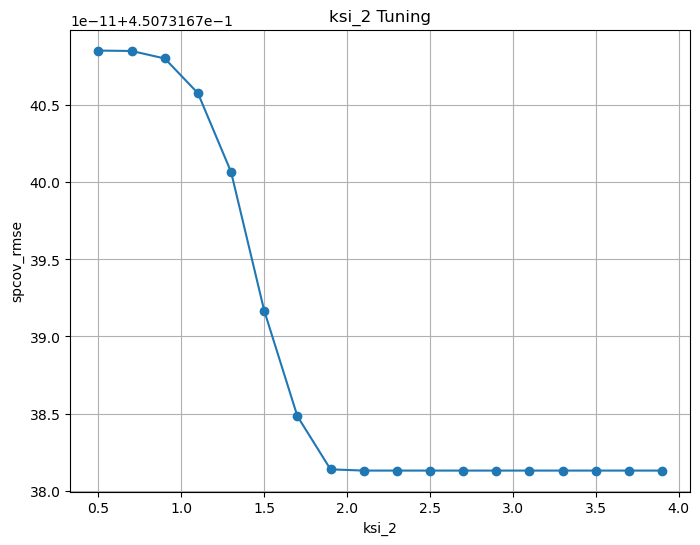

In [19]:
# Create a DataFrame
df = pd.DataFrame({'ksi_2': all_ksi_2, 'spcov_rmse': all_spcov_rmse})

# Sort the DataFrame by ksi_2
df = df.sort_values(by='ksi_2')

# Find the row with the minimum spcov_rmse
optimal_row = df[df['spcov_rmse'] == df['spcov_rmse'].min()]

# Extract the optimal ksi_2 value
optimal_ksi_2 = optimal_row['ksi_2'].values[0]

# Plot ksi_2 vs. spcov_rmse
plt.figure(figsize=(8, 6))
plt.plot(df['ksi_2'], df['spcov_rmse'], marker='o', linestyle='-')
plt.xlabel('ksi_2')
plt.ylabel('spcov_rmse')
plt.title('ksi_2 Tuning')
plt.grid(True)
plt.show()

## Main MC

In [20]:
def run_iteration(i):
    # Initialize R context for this thread or process
    initialize_r_context()
    print(f"Iteration {i + 1} started...")
    try: 
        # Step 1: Generate three fixed-effect variables
        fixed_effect_1 = np.random.normal(-2, 1, (N1, 1))
        fixed_effect_2 = np.random.normal(3, 1, (N2, 1))
        fixed_effect_3 = np.random.normal(1, 1, (T, 1))
        z = np.random.normal(mu_z, sigma_z, (N1*N2, 1))

        # Step 2: Repeat the fixed-effect variables to match the desired dimensions
        fixed_effect_1 = np.repeat(fixed_effect_1, N2 * T, axis=0)
        fixed_effect_2 = np.tile(fixed_effect_2, (N1 * T, 1))
        fixed_effect_3 = np.tile(fixed_effect_3, (N1 * N2, 1))
        z = np.tile(z, (T, 1))

        # Step 3: Stack the fixed-effect variables 
        fixed_effects_matrix = np.hstack((fixed_effect_1, fixed_effect_2, fixed_effect_3))
      


        # Step 4: Generate x
        d = np.random.normal(mu_d, sigma_d, (n, number_of_variables))
        x = z + d
        v = np.random.normal(mu_v, sigma_v, (n, 1))
        g = w * z + v

        X = np.hstack((x, fixed_effects_matrix))

        # Step 5: generate distrubances using the covariance matrix
        #omega = mc.generate_omega(case, mu_e, sigma_e, non_zero_prob, N1, N2, T, seed)
        #disturbances = mc.generate_disturbances(mu_e_vec, omega, n, t_dist_degree, lambda_parameter, mu_U, specification, seed)
        disturbances = np.random.normal(mu_e, sigma_e, (n, 1))

        # Step 6: Generate y using linear relationship: y = X * beta + FE + disturbances
        #y = np.dot(x, beta) + fixed_effects_matrix.sum(axis=1) + disturbances.flatten()
        y = np.dot(x, beta) + g.flatten() + disturbances.flatten()

        # Step 7: Transform X and y
        x_tilde, y_tilde = mc.transform_xy(X, y,number_of_variables)
        X = np.hstack((x_tilde, fixed_effects_matrix))
        y = y_tilde

        # Step 8: Estimate beta using OLS formula
        X_with_intercept = np.hstack((np.ones((n, 1)), X))  # Adding intercept term
        X_transpose = np.transpose(X_with_intercept)
        X_transpose_X_inv = np.linalg.inv(np.dot(X_transpose, X_with_intercept))
        beta_hat = np.dot(np.dot(X_transpose_X_inv, X_transpose), y)

        # Step 9: Calculate the variance-covariance matrix of beta_hat

        #OLS
        epsilon_hat = y - np.dot(X_with_intercept, beta_hat)
        omega_hat_ols = np.dot(epsilon_hat, epsilon_hat)/(n-number_of_variables-4)
        sigma_hat_ols = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_ols), X_with_intercept),X_transpose_X_inv)

        #Robust
        omega_hat_robust = np.outer(epsilon_hat, epsilon_hat)
        omega_hat_robust = np.eye(omega_hat_robust.shape[0]) * omega_hat_robust
        sigma_hat_robust = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_robust), X_with_intercept),X_transpose_X_inv)

        # spcov
        # Initialize an empty omega_hat matrix
        omega_hat_spcov = np.zeros((n, n))
        S_mat_full = np.outer(epsilon_hat, epsilon_hat)
        block_omega_hat_spcov_list = []

        # Extract blocks and average them
        init_omega_blocks = mc.extract_blocks(omega_hat_robust, block_size)
        init_omega = np.mean(init_omega_blocks, axis=0)
        S_mat_blocks = mc.extract_blocks(S_mat_full, block_size)
        S_mat = np.mean(S_mat_blocks, axis=0)
        S_mat = mc.make_positive_definite(S_mat)

        # spcov
        Lambda = mc.generate_penalty_matrix(max_penalty, block_size, ksi_1, ksi_2)
        init_omega_r = ro.r.matrix(init_omega, nrow=block_size, ncol=block_size)
        S_r = ro.r.matrix(S_mat, nrow=block_size, ncol=block_size)
        Lambda_r = ro.r.matrix(Lambda, nrow=block_size, ncol=block_size)
        spcov_result = spcov.spcov(
            init_omega_r,
            S_r,
            Lambda_r,
            step_size=0.1,
            nesterov=True,
            n_outer_steps=30,
            n_inner_steps=30,
            tol_outer=1e-04,
            thr_inner=0.01,
            backtracking=0.2,
            trace=0
        )
            
        # Append the estimated block to the list
        block_omega_hat_spcov_list.append(spcov_result[1])

        # Calculate the average block_omega_hat_spcov
        avg_block_omega_hat_spcov = np.mean(block_omega_hat_spcov_list, axis=0)

        # Fill the entire omega_hat_spcov matrix with the average block
        for block in range(len(init_omega_blocks)):
            row_start = block * block_size
            row_end = (block + 1) * block_size
            col_start = block * block_size
            col_end = (block + 1) * block_size
            omega_hat_spcov[row_start:row_end, col_start:col_end] = avg_block_omega_hat_spcov
        sigma_hat_spcov = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_spcov), X_with_intercept),X_transpose_X_inv)

        # Ledoit and Wolf (2004): 
        # Initialize an empty omega_hat matrix
        omega_hat_shrinkage = np.zeros((n, n))

        # S_mat_full = mc.make_positive_definite_2(np.outer(epsilon_hat, epsilon_hat), eta)
        S_mat_full = np.outer(epsilon_hat, epsilon_hat)

        # Extract blocks
        S_mat_blocks = mc.extract_blocks(S_mat_full, block_size)

        # Calculate the average S_mat from the list S_mat_blocks
        avg_S_mat = np.mean(S_mat_blocks, axis=0)

        # Extract subvectors of size T from epsilon_hat
        epsilon_hats = [epsilon_hat[i:i+T] for i in range(0, n, T)]

        # Create a matrix from the vectors in epsilon_hats where each vector is a row
        epsilon_hat_matrix = np.vstack(epsilon_hats)

        avg_S_mat = mc.zero_elements_below_tolerance(avg_S_mat, tolerance)
        avg_S_mat = mc.make_positive_definite_2(avg_S_mat, eta)
        mu_parameter = mc.braket_operator_identity(avg_S_mat)
        delta_parameter = mc.scaled_f_norm(avg_S_mat - mu_parameter * np.eye(block_size))**2
        beta_tilde = mc.f_norm_variance(epsilon_hat_matrix, avg_S_mat)
        beta_parameter = min(beta_tilde, delta_parameter)
        gamma_star = beta_parameter / delta_parameter

        avg_omega_hat_shrinkage_block = gamma_star * mu_parameter * np.eye(block_size) + (1 - gamma_star) * avg_S_mat
        # Fill the diagonal blocks of omega_hat_shrinkage with omega_hat_shrinkage_block
        for j in range(num_blocks):
            row_start = j * block_size
            row_end = (j + 1) * block_size
            col_start = j * block_size
            col_end = (j + 1) * block_size
            omega_hat_shrinkage[row_start:row_end, col_start:col_end] = avg_omega_hat_shrinkage_block

        # Fill the diagonal blocks of omega_hat_shrinkage with omega_hat_shrinkage_block
        sigma_hat_shrinkage = np.dot(np.dot(np.dot(np.dot(X_transpose_X_inv,X_transpose),omega_hat_shrinkage), X_with_intercept),X_transpose_X_inv)

        # Step 10: Construct the t-statistics for beta_hat
        t_stat_ols = beta_hat / np.sqrt(np.diag(sigma_hat_ols))
        t_stat_robust = beta_hat / np.sqrt(np.diag(sigma_hat_robust))
        t_stat_spcov = beta_hat / np.sqrt(np.diag(sigma_hat_spcov))
        t_stat_shrinkage = beta_hat / np.sqrt(np.diag(sigma_hat_shrinkage))

        print(f"Iteration {i + 1} completed.")

        # Clean up resources explicitly
        del x, fixed_effect_1, fixed_effect_2, fixed_effect_3, fixed_effects_matrix
        del X, disturbances, x_tilde, y_tilde, X_with_intercept
        del epsilon_hat, omega_hat_ols, sigma_hat_ols, omega_hat_robust, sigma_hat_robust
        del init_omega, Lambda, S_mat, init_omega_r, S_r, Lambda_r, spcov_result
        del omega_hat_spcov, sigma_hat_spcov, mu_parameter, delta_parameter, beta_tilde
        del beta_parameter, gamma_star, omega_hat_shrinkage, sigma_hat_shrinkage
        del avg_block_omega_hat_spcov, avg_S_mat, epsilon_hats, epsilon_hat_matrix
        del avg_omega_hat_shrinkage_block, g, v, d
        
        # Trigger Python's garbage collector to release memory
        gc.collect()
        
        return beta_hat, t_stat_ols, t_stat_robust, t_stat_spcov, t_stat_shrinkage
    finally:
        # Close the local R context
        ro.r("gc()")

In [21]:
# Initialize arrays to store results
all_beta_hat = []
all_t_stat_ols = []
all_t_stat_robust = []
all_t_stat_spcov = []
all_t_stat_shrinkage = []

# Assign optimal ksi_2 value
ksi_2 = round(optimal_ksi_2, 2)
#ksi_2 = 2   
# Define loop parameters
num_iterations = 1000  # Number of iterations
num_processes = mp.cpu_count()  # Number of processes to run in parallel

In [22]:
if __name__ == "__main__":
    # Create a thread pool executor
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        # Use a list comprehension to submit tasks to the thread pool
        futures = [executor.submit(run_iteration, i) for i in range(num_iterations)]
        
        # Retrieve results as they become available
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
# Convert the results list to arrays
all_beta_hat = np.array([result[0] for result in results])
all_t_stat_ols = np.array([result[1] for result in results])
all_t_stat_robust = np.array([result[2] for result in results])
all_t_stat_spcov = np.array([result[3] for result in results])
all_t_stat_shrinkage = np.array([result[4] for result in results])

# Now you can analyze or summarize the results as needed
average_beta_hat = np.mean(all_beta_hat, axis=0)
average_t_stat_ols = np.mean(all_t_stat_ols, axis=0)
average_t_stat_robust = np.mean(all_t_stat_robust, axis=0)
average_t_stat_spcov = np.mean(all_t_stat_spcov, axis=0)
average_t_stat_shrinkage = np.mean(all_t_stat_shrinkage, axis=0)

print("Average beta_hat:", average_beta_hat)
print("Average t_stat_ols:", average_t_stat_ols)
print("Average t_stat_robust:", average_t_stat_robust)
print("Average t_stat_spcov:", average_t_stat_spcov)
print("Average t_stat_shrinkage:", average_t_stat_shrinkage)

Iteration 1 started...
Iteration 2 started...
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 1 completed.
Iteration 2 completed.
Iteration 4 started...Iteration 3 started...

MM converged in 1 steps!
MM converged in 1 steps!
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 started...
Iteration 6 started...
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 started...Iteration 8 started...

MM converged in 1 steps!
MM converged in 1 steps!
Iteration 8 completed.
Iteration 7 completed.
Iteration 9 started...
Iteration 10 started...
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 9 completed.
Iteration 10 completed.
Iteration 11 started...
Iteration 12 started...
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 11 completed.
Iteration 12 completed.
Iteration 13 started...
Iteration 14 started...
MM converged in 1 steps!
MM converged in 1 steps!
Iteration 13 completed.
Iteration 14 complet

In [23]:
data = [
    ["Average beta_hat:"] + [f"{val:.2e}" for val in average_beta_hat],
    ["Average t_stat_ols:"] + [f"{val:.2e}" for val in average_t_stat_ols],
    ["Average t_stat_robust:"] + [f"{val:.2e}" for val in average_t_stat_robust],
    ["Average t_stat_spcov:"] + [f"{val:.2e}" for val in average_t_stat_spcov],
    ["Average t_stat_shrinkage:"] + [f"{val:.2e}" for val in average_t_stat_shrinkage]
]

# Define the headers for your table
headers = ["", "", "", "", "", ""]

# Generate the table
table = tabulate(data,  headers, tablefmt="fancy_grid")

In [24]:
print(table)

╒═══════════════════════════╤═════════╤════════╤══════════╤═══════════╤══════════╕
│                           │         │        │          │           │          │
╞═══════════════════════════╪═════════╪════════╪══════════╪═══════════╪══════════╡
│ Average beta_hat:         │ 0.0012  │   3.92 │ 3.09e-17 │ -0.000301 │ -0.00318 │
├───────────────────────────┼─────────┼────────┼──────────┼───────────┼──────────┤
│ Average t_stat_ols:       │ 0.00356 │ 231    │ 3.67e-16 │  0.00143  │ -0.052   │
├───────────────────────────┼─────────┼────────┼──────────┼───────────┼──────────┤
│ Average t_stat_robust:    │ 0.00383 │ 231    │ 3.68e-16 │  0.0011   │ -0.0517  │
├───────────────────────────┼─────────┼────────┼──────────┼───────────┼──────────┤
│ Average t_stat_spcov:     │ 0.00372 │ 231    │ 3.67e-16 │  0.00131  │ -0.0517  │
├───────────────────────────┼─────────┼────────┼──────────┼───────────┼──────────┤
│ Average t_stat_shrinkage: │ 0.00356 │ 231    │ 3.67e-16 │  0.00143  │ -0.052   │
╘═══

In [25]:
# Generate the LaTeX table
latex_table = tabulate(data, headers, tablefmt="latex")

In [26]:
output_folder = "../output/"
output_file = "table_2.tex"

In [27]:

# Save the LaTeX table to a file
with open(output_folder + output_file, "w") as f:
    f.write(latex_table)

In [28]:
import pickle

# Store the vectors in a list
vectors = [all_beta_hat, all_t_stat_ols, all_t_stat_robust, all_t_stat_spcov, all_t_stat_shrinkage]

# Specify the filename for the pickle file
pickle_file_name = "results2_vectors.pickle"

# Save the list of vectors to a pickle file
with open(pickle_file_name, 'wb') as pickle_file:
    pickle.dump(vectors, pickle_file)

print(f"Vectors saved to {pickle_file_name}")

Vectors saved to results2_vectors.pickle


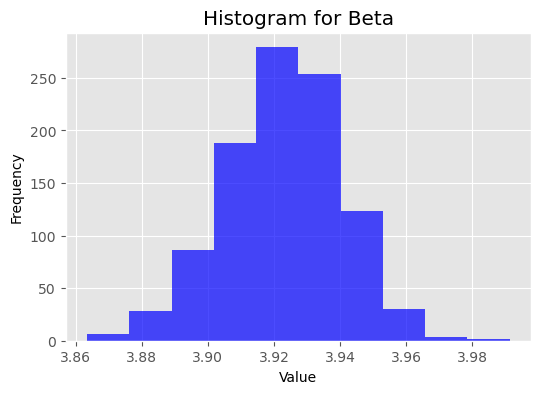

In [30]:
# Set the ggplot style, ggplot just looks better
plt.style.use('ggplot')

# Create a histogram from your vector
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.hist(all_beta_hat[:,1], bins=10, color='blue', alpha=0.7)
plt.title("Histogram for Beta")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as an image
output_filename = "beta_histogram_misspecified.png"
plt.savefig(output_folder + output_filename)

# Show the histogram
plt.show()

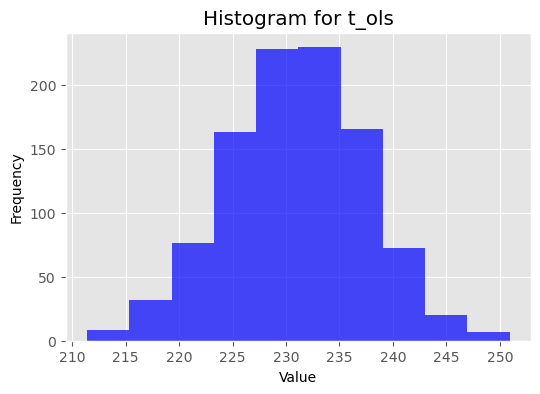

In [33]:
# Create a histogram from your vector
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.hist(all_t_stat_ols[:,1], bins=10, color='blue', alpha=0.7)
plt.title("Histogram for t_ols")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as an image
output_filename = "t_ols_histogram_misspecified.png"
plt.savefig(output_folder + output_filename)

# Show the histogram
plt.show()

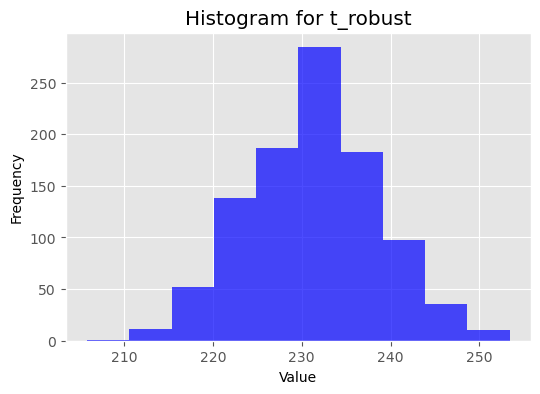

In [34]:
# Create a histogram from your vector
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.hist(all_t_stat_robust[:,1], bins=10, color='blue', alpha=0.7)
plt.title("Histogram for t_robust")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as an image
output_filename = "t_robust_histogram_misspecified.png"
plt.savefig(output_folder + output_filename)

# Show the histogram
plt.show()

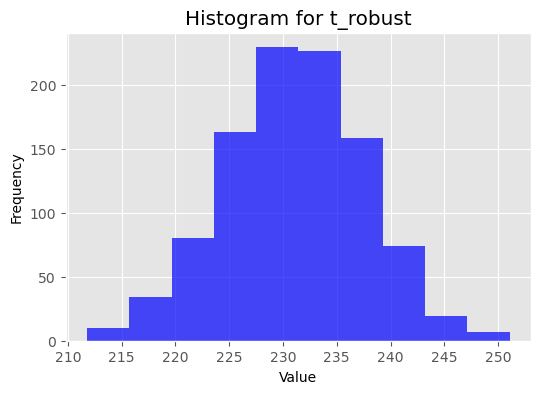

In [35]:
# Create a histogram from your vector
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.hist(all_t_stat_spcov[:,1], bins=10, color='blue', alpha=0.7)
plt.title("Histogram for t_robust")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as an image
output_filename = "t_spcov_histogram_misspecified.png"
plt.savefig(output_folder + output_filename)

# Show the histogram
plt.show()

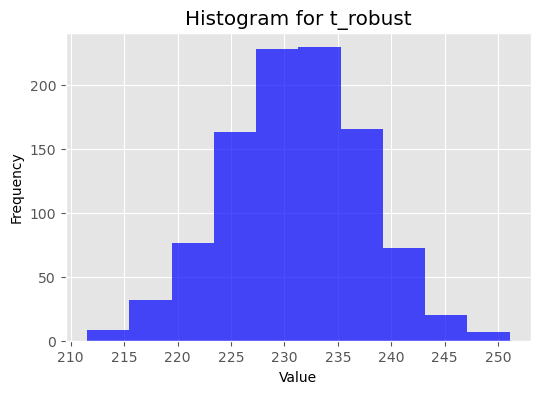

In [36]:
# Create a histogram from your vector
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.hist(all_t_stat_shrinkage[:,1], bins=10, color='blue', alpha=0.7)
plt.title("Histogram for t_robust")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)

# Save the histogram as an image
output_filename = "t_shrinkage_histogram_misspecified.png"
plt.savefig(output_folder + output_filename)

# Show the histogram
plt.show()